In [1]:
pip install geopy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from geopy.distance import geodesic

In [3]:
# Load the dataset
df = pd.read_csv("fraud_txn.csv")
df.head(3)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-12-16 12:40:56,377113842678100,"fraud_O'Connell, Botsford and Hand",home,32.65,Billy,Gallagher,M,673 Delgado Burg,...,39.4055,-75.3209,804,Insurance risk surveyor,1965-03-25,ecf3cff893d47eeec287958f2dcbe9f8,1355661656,38.988831,-75.442420,0
1,1,2019-11-10 21:29:24,502038091380,"fraud_Haley, Jewess and Bechtelar",shopping_pos,819.52,Kurt,Peters,M,7290 Ashlee Keys,...,36.6704,-93.0377,1201,"Engineer, agricultural",1980-03-18,46f3f81e3f27d015db2d80f16a663b3d,1352582964,37.502359,-92.941619,1
2,2,2019-12-31 22:11:08,30181367542315,"fraud_Tillman, Fritsch and Schmitt",misc_net,808.97,Danielle,Walker,F,9824 Mitchell Run,...,44.2415,-121.0113,2016,Local government officer,1953-12-25,cf6151929f0b38c9db2181b27423cd34,1356991868,44.931750,-121.287451,1


In [4]:
# Display basic dataset info
print(df.describe())
df.info()

         Unnamed: 0        cc_num           amt          zip           lat  \
count  15506.000000  1.550600e+04  15506.000000  15506.00000  15506.000000   
mean    7752.500000  4.160084e+17    292.231916  48784.67361     38.603331   
std     4476.340972  1.303858e+18    370.867673  27120.13128      5.122948   
min        0.000000  6.041621e+10      1.000000   1257.00000     20.027100   
25%     3876.250000  1.800401e+14     20.170000  25526.00000     34.778900   
50%     7752.500000  3.523898e+15     85.785000  48034.00000     39.401500   
75%    11628.750000  4.642255e+15    391.812500  72042.00000     41.940400   
max    15505.000000  4.992346e+18   6337.250000  99783.00000     66.693300   

               long      city_pop     unix_time     merch_lat    merch_long  \
count  15506.000000  1.550600e+04  1.550600e+04  15506.000000  15506.000000   
mean     -90.275315  9.084253e+04  1.348843e+09     38.594294    -90.275188   
std       14.051839  3.043486e+05  1.331010e+07      5.16186

In [5]:
# Check for missing values
print("Missing Values in Each Column:")
print(df.isnull().sum())

Missing Values in Each Column:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [6]:
# Encode gender column (Male = 1, Female = 0)
df['gender'] = df['gender'].map({'M': 1, 'F': 0})

In [7]:
# One-hot encode categorical variables
categorical_columns = ['merchant', 'category', 'state', 'job']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

print("\nDataset after One-Hot Encoding:")
df.head(3)


Dataset after One-Hot Encoding:


,Unnamed: 0,trans_date_trans_time,cc_num,amt,first,last,gender,street,city,zip,...,job_Visual merchandiser,job_Volunteer coordinator,job_Warden/ranger,job_Warehouse manager,job_Waste management officer,job_Water engineer,job_Water quality scientist,job_Web designer,job_Wellsite geologist,job_Writer
0,0,2019-12-16 12:40:56,377113842678100,32.65,Billy,Gallagher,1,673 Delgado Burg,Greenwich,8323,...,0,0,0,0,0,0,0,0,0,0
1,1,2019-11-10 21:29:24,502038091380,819.52,Kurt,Peters,1,7290 Ashlee Keys,Kissee Mills,65680,...,0,0,0,0,0,0,0,0,0,0
2,2,2019-12-31 22:11:08,30181367542315,808.97,Danielle,Walker,0,9824 Mitchell Run,Powell Butte,97753,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Normalize selected numerical columns
columns_to_normalize = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']
scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [9]:
# Create an age column by calculating the difference between the transaction date and dob
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], errors='coerce')
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

print("Dataset after adding Age column:")
print(df[['dob', 'trans_date_trans_time', 'age']].head(3))

Dataset after adding Age column:
         dob trans_date_trans_time  age
0 1965-03-25   2019-12-16 12:40:56   54
1 1980-03-18   2019-11-10 21:29:24   39
2 1953-12-25   2019-12-31 22:11:08   66


In [10]:
# Calculate distance between transaction location and merchant location
def calculate_distance(row):
    return geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).kilometers

df['transaction_merchant_distance'] = df.apply(calculate_distance, axis=1)

print("\nDataset after adding Transaction-Merchant Distance:")
print(df[['lat', 'long', 'merch_lat', 'merch_long', 'transaction_merchant_distance']].head())


Dataset after adding Transaction-Merchant Distance:
        lat      long  merch_lat  merch_long  transaction_merchant_distance
0  0.156589  1.064266   0.076436    1.054155                       8.934049
1 -0.377320 -0.196592  -0.211546   -0.189501                      18.347417
2  1.100607 -2.187399   1.227785   -2.204021                      14.183901
3  0.498258 -0.772926   0.482410   -0.756676                       2.518553
4  1.683415 -1.907754   1.514448   -1.874996                      19.035864


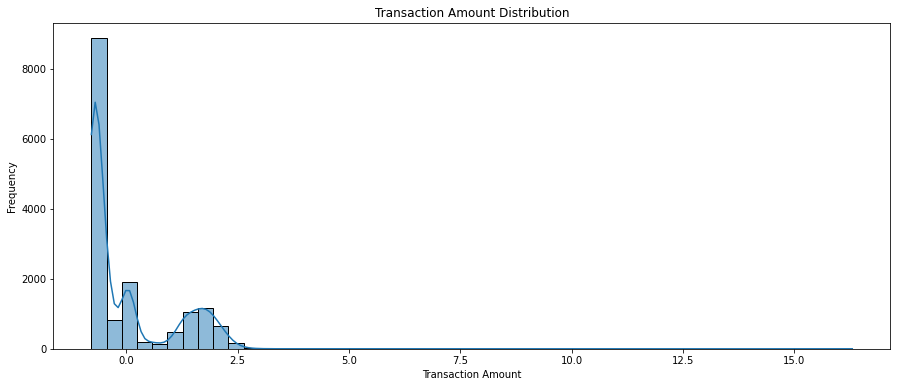

In [11]:
# Analyze spending patterns using amount distribution
plt.figure(figsize=(15, 6))
sns.histplot(df['amt'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

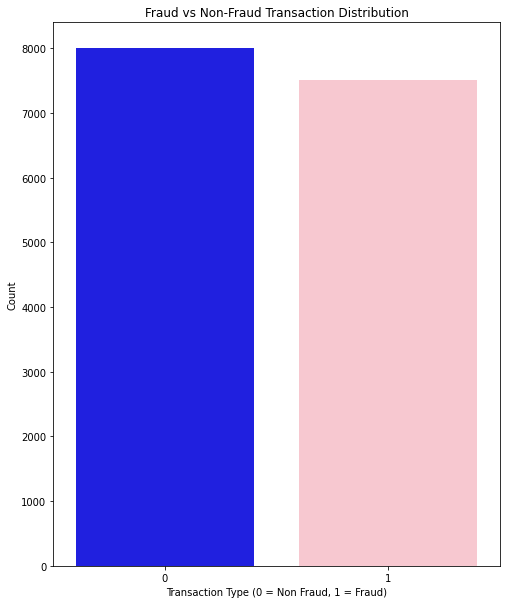

In [12]:
# Visualize fraud vs. non-fraud distribution
plt.figure(figsize=(8, 10))
sns.countplot(x='is_fraud', data=df, palette=['blue', 'pink'])
plt.title("Fraud vs Non-Fraud Transaction Distribution")
plt.xlabel("Transaction Type (0 = Non Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

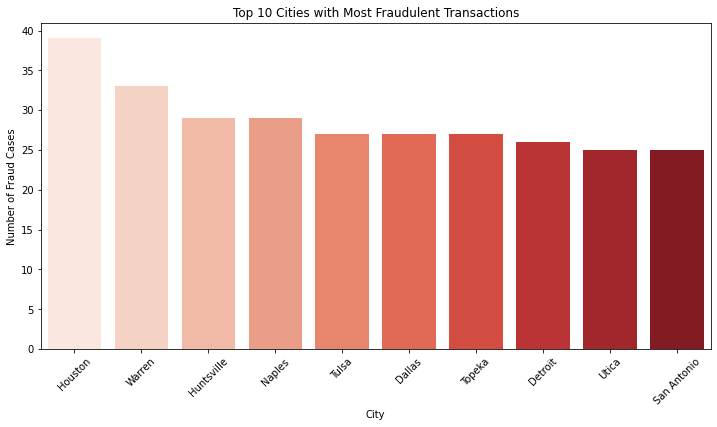

In [13]:
# Identify cities with the most fraud
plt.figure(figsize=(12, 6))
fraud_city_counts = df[df['is_fraud'] == 1]['city'].value_counts().head(10)
sns.barplot(x=fraud_city_counts.index, y=fraud_city_counts.values, palette='Reds')
plt.title("Top 10 Cities with Most Fraudulent Transactions")
plt.xlabel("City")
plt.ylabel("Number of Fraud Cases")
plt.xticks(rotation=45)
plt.show()

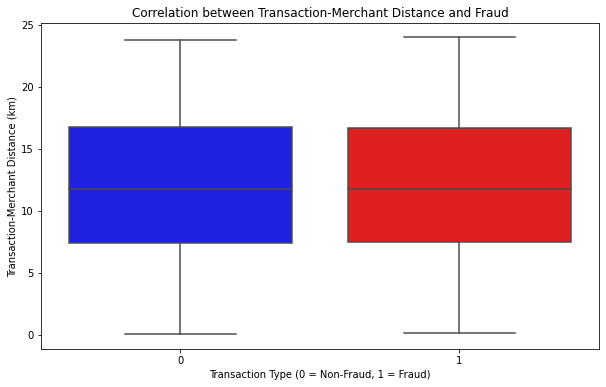

In [14]:
# Show correlation between transaction_merchant_distance and is_fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['is_fraud'], y=df['transaction_merchant_distance'], palette=['blue', 'red'])
plt.title("Correlation between Transaction-Merchant Distance and Fraud")
plt.xlabel("Transaction Type (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Transaction-Merchant Distance (km)")
plt.show()

In [15]:
df.head()
## need to drop some columns

,Unnamed: 0,trans_date_trans_time,cc_num,amt,first,last,gender,street,city,zip,...,job_Warden/ranger,job_Warehouse manager,job_Waste management officer,job_Water engineer,job_Water quality scientist,job_Web designer,job_Wellsite geologist,job_Writer,age,transaction_merchant_distance
0,0,2019-12-16 12:40:56,377113842678100,-0.699954,Billy,Gallagher,1,673 Delgado Burg,Greenwich,8323,...,0,0,0,0,0,0,0,0,54,8.934049
1,1,2019-11-10 21:29:24,502038091380,1.421815,Kurt,Peters,1,7290 Ashlee Keys,Kissee Mills,65680,...,0,0,0,0,0,0,0,0,39,18.347417
2,2,2019-12-31 22:11:08,30181367542315,1.393367,Danielle,Walker,0,9824 Mitchell Run,Powell Butte,97753,...,0,0,0,0,0,0,0,0,66,14.183901
3,3,2020-04-09 17:23:25,376445266762684,-0.613128,Rachel,Lowe,0,372 Jeffrey Course,Sutherland,69165,...,0,0,0,0,0,0,0,0,38,2.518553
4,4,2019-12-22 15:03:23,3500969075198072,-0.617577,Kenneth,Sanchez,1,0110 Ashley Forest,Tekoa,99033,...,0,0,0,0,0,0,0,0,20,19.035864


In [18]:
# Remove irrelevant columns before splitting the dataset
columns_to_remove = ['Unnamed: 0','trans_date_trans_time', 'dob', 'trans_num', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip','transaction_merchant_distance','unix_time']
df = df.drop(columns=columns_to_remove, errors='ignore')

In [22]:
df.head()

,amt,gender,lat,long,city_pop,merch_lat,merch_long,is_fraud,merchant_fraud_Abbott-Steuber,merchant_fraud_Abernathy and Sons,...,job_Volunteer coordinator,job_Warden/ranger,job_Warehouse manager,job_Waste management officer,job_Water engineer,job_Water quality scientist,job_Web designer,job_Wellsite geologist,job_Writer,age
0,-0.699954,1,0.156589,1.064266,-0.295850,0.076436,1.054155,0,0,0,...,0,0,0,0,0,0,0,0,0,54
1,1.421815,1,-0.377320,-0.196592,-0.294545,-0.211546,-0.189501,1,0,0,...,0,0,0,0,0,0,0,0,0,39
2,1.393367,0,1.100607,-2.187399,-0.291867,1.227785,-2.204021,1,0,0,...,0,0,0,0,0,0,0,0,0,66
3,-0.613128,0,0.498258,-0.772926,-0.292613,0.482410,-0.756676,0,0,0,...,0,0,0,0,0,0,0,0,0,38
4,-0.617577,1,1.683415,-1.907754,-0.295551,1.514448,-1.874996,0,0,0,...,0,0,0,0,0,0,0,0,0,20


In [23]:
# Split the dataset into training and testing sets
X = df.drop(columns=['is_fraud'])  # Features
y = df['is_fraud']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nDataset split into Training and Test sets:")
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")


Dataset split into Training and Test sets:
Training set size: 12404 rows
Test set size: 3102 rows


In [29]:
# Define base models for stacking
base_models = [
    ('decision_tree', DecisionTreeClassifier()),
    ('random_forest', RandomForestClassifier(n_estimators=50, n_jobs=-1))
]

# Define meta-model
meta_model = LogisticRegression()

# Create stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, passthrough=True)

# Train the stacking model
print("\nTraining Stacking Model...")
stacking_model.fit(X_train, y_train)


Training Stacking Model...


/voc/work/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('decision_tree', DecisionTreeClassifier()),
                               ('random_forest',
                                RandomForestClassifier(n_estimators=50,
                                                       n_jobs=-1))],
                   final_estimator=LogisticRegression(), passthrough=True)

In [30]:
from model_helper import applyModel_classification
applyModel_classification(stacking_model, X_train, y_train, X_test, y_test)

/voc/work/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Score:  1.0
Test Score:  0.9593810444874274

################## Classification Report : Train ##########################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6400
           1       1.00      1.00      1.00      6004

    accuracy                           1.00     12404
   macro avg       1.00      1.00      1.00     12404
weighted avg       1.00      1.00      1.00     12404

_______________________________________________________________________________
################## Classification Report : Test ##########################
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1600
           1       0.96      0.96      0.96      1502

    accuracy                           0.96      3102
   macro avg       0.96      0.96      0.96      3102
weighted avg       0.96      0.96      0.96      3102

________________________________________________________________

StackingClassifier(estimators=[('decision_tree', DecisionTreeClassifier()),
                               ('random_forest',
                                RandomForestClassifier(n_estimators=50,
                                                       n_jobs=-1))],
                   final_estimator=LogisticRegression(), passthrough=True)